### Local


In [1]:
import numpy as np
import pandas as pd
import os
import sys

import matplotlib.pyplot as plt

import pyspark.sql.functions as F
import pyspark.sql.types as T

os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

### Load Parquet files

In [2]:
# load parquet files
parquet_path = 'G:\\_data'
df = spark.read.parquet(parquet_path)

In [3]:
# count rows
df.count()

264630487

In [4]:
# show schema
df.printSchema()

root
 |-- location_id: long (nullable = true)
 |-- sensors_id: long (nullable = true)
 |-- location: string (nullable = true)
 |-- datetime: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- lat.1: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- lon.1: double (nullable = true)
 |-- parameter: string (nullable = true)
 |-- units: string (nullable = true)
 |-- value: double (nullable = true)



### Drop unused columns

Some source files have errant lat.1 and lon.1 columns. They are all NULL for all rows, and can be safely dropped.

In [5]:
# drop lat.1 and lon.1
df = df.drop('lat.1', 'lon.1')

#### Drop NULLs

In [6]:
# remove nulls from value column
df = df.na.drop(subset=['location_id', 'location', 'value', 'parameter'])

#### Drop rows with Value 0 or less

In [7]:
df.filter(F.col("value") <= 0).count()

21804728

In [8]:
# keep only values > 0
df = df.filter(F.col("value") > 0)

### Filter out Latitude = Longitude

Some rows are for locations that have the exact same longitude and latitude, which shouldn't be.

The names of these places are often for locations not in the US. We'll filter them out.  

In [9]:
# find rows where latitude and longitude are the exact same
count_lat_long_same = df.filter(F.col('lat') == F.col('lon')).count()
print(f'Number of rows where lat and long are the same: {count_lat_long_same}')

# example
df.filter(F.col('lat') == F.col('lon')).select('location', 'lat', 'lon').limit(1).show()

# filter out rows where lat and lon are equal
df = df.filter(F.col('lat') != F.col('lon'))

Number of rows where lat and long are the same: 3303273
+--------------------+----------+----------+
|            location|       lat|       lon|
+--------------------+----------+----------+
|20210430 control ...|-6.5952312|-6.5952312|
+--------------------+----------+----------+



### Pollutants and their Units

- we'll examine the pollutants and their units, and remove some we aren't interested in.
- we'll also align things like the PM25's µg/m³ units:  µ (micro sign, Unicode: U+00B5) and μ (Greek letter mu, Unicode: U+03BC) are different characters. 

In [10]:
# get unique parameters and their units
df_pollutants = df.groupBy('parameter', 'units').count().sort('count')
df_pollutants.show(100)

+----------------+-------------+--------+
|       parameter|        units|   count|
+----------------+-------------+--------+
|        pm25-old|         ugm3|     157|
|            pm25|          ppm|     197|
|             no2|          ppb|    9783|
|            pm25|        μg/m³|  139182|
|             nox|        µg/m³|  275166|
|           um100|particles/cm³|  457663|
|              no|        µg/m³|  532918|
|              bc|        µg/m³|  793530|
|             pm4|        µg/m³|  998267|
|        pressure|          hpa| 1023925|
|              no|          ppm| 1090600|
|             nox|          ppm| 1234171|
|           um050|particles/cm³| 1239630|
|             voc|          iaq| 1776441|
|           um025|particles/cm³| 3143453|
|relativehumidity|            %| 3157537|
|        pressure|           mb| 4725105|
|           um010|particles/cm³| 4754039|
|           um005|particles/cm³| 4838150|
|           um003|particles/cm³| 5114292|
|        humidity|            %| 5

In [11]:
# drop some variants of pm25 we aren't interested in
df = df.filter((F.col('parameter') != 'pm25') | (F.col('units') != 'ppm'))

# any units of 'ppb' have scant rows
df = df.filter(F.col('units') != 'ppb')

# any rows with units of 'particles/cm3' we aren't interested in
df = df.filter(F.col('units') != 'particles/cm³')

# filter out some other pollutants we're not interested in
df = df.filter(~F.col('parameter').isin(['pm25-old', 'ch4', 'bc', 'nox', 'voc', 'no', 'co2', 'pm4']))

# align ug/m3 units
# NOTE: the string values below for ug/m3 should not be touched, retyped, etc. The micro/mu are specific characters that look the same, but are different
df = df.withColumn('units', F.when(F.col('units') == 'μg/m³', 'µg/m³').otherwise(F.col('units')))

#### Convert Temperatures in C to F

In [12]:
# convert temperatures with units C to F
df = df.withColumn('value',
    F.when((F.col('parameter') == 'temperature') & (F.col('units') == 'c'),
        (F.col('value') * 1.8) + 32)
        .otherwise(F.col('value')
    )
)

# change all units to F when parameter is 'temperature'
df = df.withColumn('units', F.when(F.col('parameter') == 'temperature', 'f').otherwise(F.col('units')))

#### Change Pressure Units

In [13]:
# 1 hectopascal equals 1 millibar, so we'll just change the units to mb
df = df.withColumn('units', F.when(F.col('units') == 'hpa', 'mb').otherwise(F.col('units')))

#### Convert units for some pollutants

**NOTE**: skipping this for now. Conversions vary depending on factors, and for now we'll concetrate on rows with the proper units

- for some pollutants, there are measurements in both ug/m3 and ppm
- the AQI calculator (EPA algorithm) expects that pollutants have certain units:
  - CO - ppm *
  - NO2 - ppb *
  - O3 - ppm *
  - PM10 - ug/m3
  - PM25 - ug/m3
  - SO2 - ppb *
- starred units need conversion in this dataset

In [14]:
# TODO: from web research, the converions between ug/m3 and ppb can be quite different depending on temp and pressure, etc. For now, we'll just only use rows with the proper units.

# get a few rows where parameter is 'co' and unit is 'ug/m3'
# z = df.filter((F.col('parameter') == 'co') & (F.col('units') == 'µg/m³')).limit(5)

# NOTE: For now, removing rows with improper units
df = df.filter(~(F.col('parameter').isin(['co', 'no2', 'so2']) & (F.col('units') == 'µg/m³')))

In [15]:
# convert no2 and so2 to ppb
df = df.withColumn('value',
    F.when(
        (F.col('parameter').isin(['so2', 'no2'])) & (F.col('units') == 'ppm'),
        F.col('value') * 1000)
        .otherwise(F.col('value')
    )
)
df = df.withColumn('units',
    F.when(
        (F.col('parameter').isin(['so2', 'no2'])) & (F.col('units') == 'ppm'),
        'ppb')
        .otherwise(F.col('units')
    )
)

#### After this work on Parameters and Units, we'll create and cache the Pollutants for later use

In [16]:
df_pollutants = df.groupBy('parameter', 'units').count().drop('count').sort('parameter', 'units').cache()
df_pollutants.show(100)

+----------------+-----+
|       parameter|units|
+----------------+-----+
|              co|  ppm|
|        humidity|    %|
|             no2|  ppb|
|              o3|  ppm|
|              o3|µg/m³|
|             pm1|µg/m³|
|            pm10|µg/m³|
|            pm25|µg/m³|
|        pressure|   mb|
|relativehumidity|    %|
|             so2|  ppb|
|     temperature|    f|
+----------------+-----+



#### Daily Averages

- average rows per day, per location, per parameter and unit

In [17]:
# convert datetime column to yyyy-mm-dd as 'date'
df = df.withColumn('date', F.date_format(F.col('datetime'), 'yyyy-MM-dd'))

# as we're averaging on day, we don't need the precision of the datetime column
df = df.drop('datetime')

# also don't need sensors_id or units column anymore
df = df.drop('sensors_id', 'units')

df_daily = df.groupBy('location_id', 'parameter', 'date').agg(
    F.first('location').alias('location'),
    F.first('lat').alias('lat'),
    F.first('lon').alias('lon'),
    F.avg('value').alias('value')
).cache()

In [ ]:
df_daily.show()

#### Pivot Pollutants

In [18]:
# pivot parameter column
df_pivot = df_daily.groupBy('location_id', 'location', 'date', 'lat', 'lon').pivot('parameter').agg(F.avg('value'))

In [ ]:
df_pivot.limit(10).show()

##### Drop rows where PM25 is null

In [ ]:
# drop rows where pm25 is null
df_pivot = df_pivot.na.drop(subset=['pm25'])

### Geocode

NOTE: this is on hold for now: geopy is rate-limiting calls. Instead we'll use rough latitude and longitude bounding box for US

We'll Geocode the latitude and longitude values to:

- cull locations that aren't in the US
- use the added categorical geographic information (State, County, etc) in analysis

In [ ]:
from geopy.geocoders import Nominatim

def geocode(lat, lon):
    geolocator = Nominatim(user_agent="group_project")
    location = geolocator.reverse((lat, lon), exactly_one=True)
    address = location.raw['address']
    # we only need city, state, county, country, and country_code
    geocode_info =  {
        'city': address.get('city', ''),
        'state': address.get('state', ''),
        'county': address.get('county', ''),
        'country': address.get('country', ''),
        'country_code': address.get('country_code', '')
    }
    return geocode_info

geocode_udf = F.udf(geocode, T.MapType(T.StringType(), T.StringType()))

#### Geocoding was removed for now as we're hitting Geopy rate limits

In [ ]:
# TODO: fix rate limit problems
"""
df = df_pivot.withColumn('geotag', geocode_udf(F.col('lat'), F.col('lon')))
df = df.selectExpr("*", "geotag['city'] as city", "geotag['state'] as state", "geotag['county'] as county", "geotag['country'] as country", "geotag['country_code'] as country_code")

# drop geotag column
df = df.drop('geotag').cache()

# drop rows that aren't in the United States
df = df.filter(F.col('country_code') == 'us')
"""

'\ndf = df_pivot.withColumn(\'geotag\', geocode_udf(F.col(\'lat\'), F.col(\'lon\')))\ndf = df.selectExpr("*", "geotag[\'city\'] as city", "geotag[\'state\'] as state", "geotag[\'county\'] as county", "geotag[\'country\'] as country", "geotag[\'country_code\'] as country_code")\n\n# drop geotag column\ndf = df.drop(\'geotag\').cache()\n\n# drop rows that aren\'t in the United States\ndf = df.filter(F.col(\'country_code\') == \'us\')\n'

#### For now, we'll use rough Latitude / Longitude bounding box to limit to US stations

In [ ]:
# latitude and longitude bounding box for US
bounding_north = 49.35
bounding_south = 24.4
bounding_east = -66.93
bounding_west = -125

df = df_pivot.filter((F.col('lat') >= bounding_south) & (F.col('lat') <= bounding_north) & (F.col('lon') >= bounding_west) & (F.col('lon') <= bounding_east))

### AQI

In [ ]:
import aqi

def calculate_aqi(pm10, pm25, co, no2, o3, so2):

    try:
        pollutants = []

        pollutants.append((aqi.POLLUTANT_PM10, pm10)) if pm10 else None
        pollutants.append((aqi.POLLUTANT_PM25, pm25)) if pm25 else None
        pollutants.append((aqi.POLLUTANT_CO_8H, co)) if co else None
        pollutants.append((aqi.POLLUTANT_NO2_1H, no2)) if no2 else None
        pollutants.append((aqi.POLLUTANT_O3_8H, o3)) if o3 else None
        pollutants.append((aqi.POLLUTANT_SO2_1H, so2)) if so2 else None

        return(float(aqi.to_aqi(pollutants)))

    except Exception as e:
        return None
# -------------------------------

# register UDF
aqi_udf = F.udf(calculate_aqi, T.FloatType())

# add AQI column
df = df.withColumn('aqi', aqi_udf(F.col('pm10'), F.col('pm25'), F.col('co'), F.col('no2'), F.col('o3'), F.col('so2')))

In [ ]:
def aqi_category(aqi_score):
    if aqi_score is None:
        return None
    elif aqi_score <= 50:
        return "Good"
    elif aqi_score <= 100:
        return "Moderate"
    elif aqi_score <= 150:
        return "Unhealthy for Sensitive Groups"
    elif aqi_score <= 200:
        return "Unhealthy"
    elif aqi_score <= 300:
        return "Very Unhealthy"
    elif aqi_score > 300:
        return "Hazardous"
    else:
        return None

# register UDF
aqi_category_udf = F.udf(aqi_category, T.StringType())

df = df.withColumn("aqi_category", aqi_category_udf(F.col("aqi")))

### Model - Linear Regression

In [31]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

df_model = df

#### Looking at Average PM2.5 values

In [ ]:
pm25_df = df_model.toPandas()

# sort by date
pm25_df = pm25_df.sort_values('date')

plt.figure(figsize=(10, 6))
plt.plot(pm25_df['date'], pm25_df['pm25'], marker='o', linestyle='-')

plt.title('PM2.5 Values in US')
plt.xlabel('Date')
plt.ylabel('Average PM2.5 (µg/m³)')
plt.grid(True)

plt.xticks(rotation=45)

x_tick_spacing = 8

# reduce x labels
plt.gca().set_xticks(pm25_df['date'][::x_tick_spacing])

# Customize the tick labels to show only the year
plt.gca().set_xticklabels([date[:7] for date in pm25_df['date'][::x_tick_spacing]])

plt.tight_layout()
plt.show()

#### For linear regression, will use a timestamp column (UNIX epoch)

In [55]:
# converting date column to timestamp 
df_model = df_model.withColumn('timestamp', F.unix_timestamp(F.col('date'), 'yyyy-MM-dd'))

#### Split data into  training and tests sets, create model

In [236]:
# splitting into test and training set
train_df = df_model.filter(F.col('date') < '2023-01-01')
test_df = df_model.filter(F.col('date') >= '2023-01-01')

# creating feature vectors
assembler = VectorAssembler(inputCols=['timestamp'], outputCol='features', handleInvalid='skip')
train_df = assembler.transform(train_df)
test_df = assembler.transform(test_df)

# creating a linear regression model
lr_model = LinearRegression(featuresCol='features', labelCol='pm25').fit(train_df)

# print the coefficients and intercept for linear regression
print(f"Coefficients: {lr_model.coefficients}")
print(f"Intercept: {lr_model.intercept}")

Coefficients: [4.911536556608209e-08]
Intercept: -70.7635985072132


In [237]:
# predicting pm2.5 values based on linear regression model
predictions = lr_model.transform(test_df)

_predictions = predictions.select('date', 'pm25', 'prediction')
_predictions.show()

# # evaluating the model with root mean squared error
evaluator = RegressionEvaluator(labelCol="pm25", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

+----------+-------------------+------------------+
|      date|               pm25|        prediction|
+----------+-------------------+------------------+
|2023-10-14| 3.9875000000000003|12.598280837961141|
|2023-01-23|              4.625|11.478155810861068|
|2023-08-02| 15.795833333333336|12.288500404262749|
|2023-11-13| 10.791666666666666|12.725764680824454|
|2023-07-24|              10.75|12.250308295998565|
|2023-05-10|  2.385714285714286|11.932040727130342|
|2023-10-07|0.13913043478260875|12.568575864866773|
|2023-10-02| 21.948809523809523| 12.54735802694222|
|2023-10-07| 27.211815561959643|12.568575864866773|
|2024-03-10|                0.1| 13.22650565584378|
|2023-04-05|                5.5|11.783515861658515|
|2023-10-02| 0.6363636363636364| 12.54735802694222|
|2023-10-06|  6.410000000000001|12.564332297281865|
|2023-08-08|  5.718181818181818|12.313961809772195|
+----------+-------------------+------------------+

Root Mean Squared Error (RMSE) on test data = 8.955761060050015

In [240]:
# get max and min from predictions_df
max_prediction = predictions_df['prediction'].max()
min_prediction = predictions_df['prediction'].min()

print(f'Max prediction: {max_prediction}')
print(f'Min prediction: {min_prediction}')


Max prediction: 13.22650565584378
Min prediction: 11.478155810861068


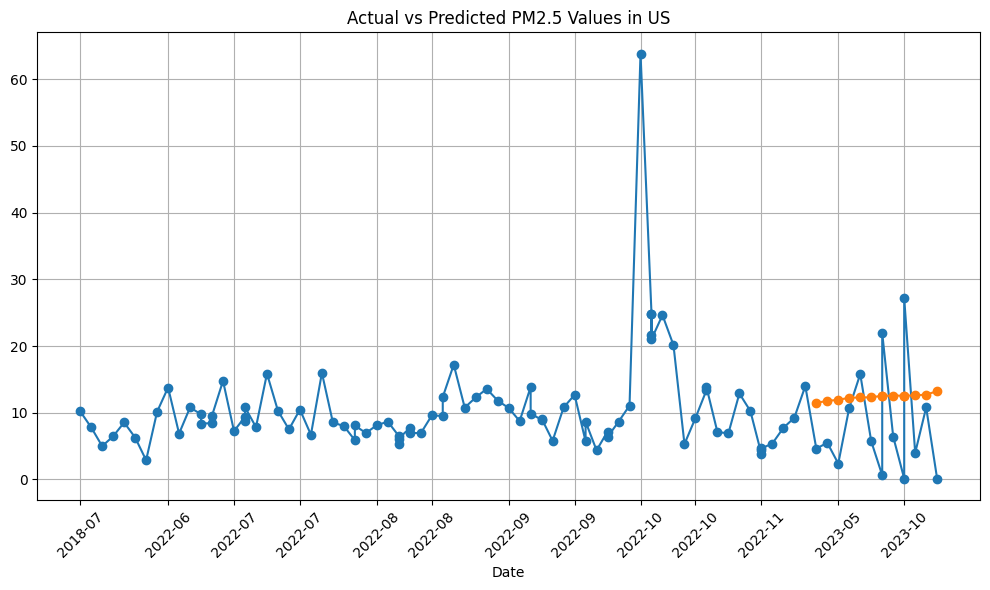

In [244]:
predictions_df = _predictions.toPandas()

# sort by date
predictions_df = predictions_df.sort_values('date').reset_index(drop=True)

# plotting predicted vs actual pm2.5 values
plt.figure(figsize=(10, 6))
# plt.plot(predictions_df['date'], predictions_df['pm25'], marker='o', linestyle='-', label='Actual')
plt.plot(pm25_df['date'], pm25_df['pm25'], marker='o', linestyle='-')
plt.plot(predictions_df['date'], predictions_df['prediction'], marker='o', linestyle='-', label='Predicted')

plt.title('Actual vs Predicted PM2.5 Values in US')
plt.xlabel('Date')
plt.grid(True)

plt.xticks(rotation=45)

x_tick_spacing = 8

# reduce x labels
plt.gca().set_xticks(pm25_df['date'][::x_tick_spacing])

# Customize the tick labels to show only the year
plt.gca().set_xticklabels([date[:7] for date in pm25_df['date'][::x_tick_spacing]])


plt.tight_layout()
plt.show()